### HR / Исследование причин неудовлетворенности / увольнения сотрудников

In [1]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats as sts
from scipy.stats import mannwhitneyu

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import statistics

from IPython.display import Image

%matplotlib inline

1.  Загрузить файл hr.csv

In [2]:
url = "HR.csv"
data = pd.read_csv(url)
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


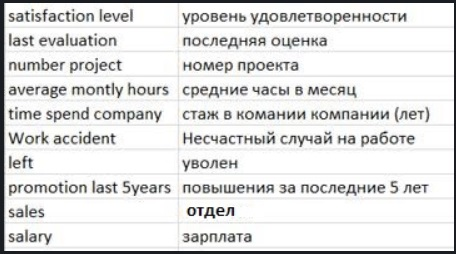

In [3]:
# поля датасета
Image('HR.jpg', width=400)

In [4]:
# формируем словари значений справочников по полям salary (уровень зарплаты) и sales (отделы)
dept_dict = {data.sales.unique()[n] :n for n in range(len(data.sales.unique()))}
salary_dict = {data.salary.unique()[n] :n for n in range(len(data.salary.unique()))}
print('Словарь подразделений:', dept_dict)
print('Словарь уровней оплаты труда:', salary_dict)

Словарь подразделений: {'sales': 0, 'accounting': 1, 'hr': 2, 'technical': 3, 'support': 4, 'management': 5, 'IT': 6, 'product_mng': 7, 'marketing': 8, 'RandD': 9}
Словарь уровней оплаты труда: {'low': 0, 'medium': 1, 'high': 2}


In [5]:
# кодируем значения полей salary и sales
data['dept']  = data['sales'].map(dept_dict)
data['salary_rate'] = data['salary'].map(salary_dict)
data.tail()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary,dept,salary_rate
14994,0.40,0.57,2,151,3,0,1,0,support,low,4,0
14995,0.37,0.48,2,160,3,0,1,0,support,low,4,0
14996,0.37,0.53,2,143,3,0,1,0,support,low,4,0
14997,0.11,0.96,6,280,4,0,1,0,support,low,4,0
14998,0.37,0.52,2,158,3,0,1,0,support,low,4,0


In [6]:
# присваиваем столбцам более читаемые / понятные названия
data.columns = ['satisfact',            # удовлетворенность       | satisfaction_lavel
                'rate',                 # рейтинг                  | last_evaluation 
                'load_project',         # загруженность проектами  | number_project
                'load_time',            # загруженность по времени | average_monthly_hours
                'seniority',            # стаж                     | time_spend_company
                'accident',             # несчастные случаи        | Work_accident
                'left',                 # факт увольнения          | left
                'step-up',              # повышения по службе      | promotion_last_5_years
                'sales',                # департамент / имя        | sales
                'salary',               # уровень оплаты / текст   | salary                  
                'dept',                 # департамент / код        | 
                'salary_rate']          # уровень оплаты / код     |  
data.tail(1)

,satisfact,rate,load_project,load_time,seniority,accident,left,step-up,sales,salary,dept,salary_rate
14998,0.37,0.52,2,158,3,0,1,0,support,low,4,0


2.   Рассчитать основные статистики для переменных (среднее, медиана, мода, мин/макс, сред. отклонение)

In [7]:
data.describe()

,satisfact,rate,load_project,load_time,seniority,accident,left,step-up,dept,salary_rate
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268,3.339823,0.594706
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281,2.820837,0.637183
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000,3.000000,1.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000,6.000000,1.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000,9.000000,2.000000


In [8]:
# расчет моды
for i in range(data.shape[1]):
    try:    
        print("Мода  ", data.columns[i], "= ", 
              statistics.mode(data.iloc[:, i]))
    except statistics.StatisticsError:
        print("В отношении  ", data.columns[i], "нет уникальной моды")

Мода   satisfact =  0.1
Мода   rate =  0.55
Мода   load_project =  4
В отношении   load_time нет уникальной моды
Мода   seniority =  3
Мода   accident =  0
Мода   left =  0
Мода   step-up =  0
Мода   sales =  sales
Мода   salary =  low
Мода   dept =  0
Мода   salary_rate =  0


In [9]:
# варианты / значения моды по полю load_time
data.groupby('load_time').size().sort_values(ascending = [False]).head(2)

load_time
135    153
156    153
dtype: int64

6-9. Cколько работников работает в каждом департаменте
Распределение сотрудников по зарплатам и департаментам
Cколько сотрудников покинули компанию

In [10]:
print('Распределение сотрудников по департаментам')
table_01 = pd.pivot_table(data, 
                          values =['rate'],  
                          index = ['sales'],
                          columns = ['left'], 
                          aggfunc = ['count'])

table_01.columns = ['Работает', 'Уволено']
table_01['Уволено, %'] =    (100 * table_01['Уволено'] / 
                            (table_01['Работает'] + table_01['Уволено'])).round(2)
table_01

Распределение сотрудников по департаментам


,Работает,Уволено,"Уволено, %"
sales,,,
IT,954,273,22.25
RandD,666,121,15.37
accounting,563,204,26.60
hr,524,215,29.09
management,539,91,14.44
marketing,655,203,23.66
product_mng,704,198,21.95
sales,3126,1014,24.49
support,1674,555,24.90


In [11]:
print('Распределение сотрудников по зарплатам и стажу')
table_02 = pd.pivot_table(data, 
                          values =['rate'],  
                          index = ['salary_rate'],
                          columns = ['seniority'], 
                          aggfunc = ['count'])
table_02.columns = ['2','3','4','5','6','7','8','10',]
table_02

Распределение сотрудников по зарплатам и стажу


,2,3,4,5,6,7,8,10
salary_rate,,,,,,,,
0,1527,3205,1300,799,333,36,60,56
1,1414,2718,1084,608,330,114,84,94
2,303,520,173,66,55,38,18,64


In [12]:
print('Распределение сотрудников по департаментам и зарплатам')
table_03 = pd.pivot_table(data[data['left']==0], 
                          values =['left'],  
                          index = ['sales'],
                          columns = ['salary'], 
                          aggfunc = ['count'])
table_03.columns = ['высокий', 'низкий', 'средний']
table_03.iloc[:,[0,2,1]]

Распределение сотрудников по департаментам и зарплатам


,высокий,средний,низкий
sales,,,
IT,79,438,437
RandD,47,310,309
accounting,69,235,259
hr,39,242,243
management,224,194,121
marketing,71,308,276
product_mng,62,296,346
sales,255,1469,1402
support,133,784,757


In [13]:
print('Компанию покинули', data.loc[data['left']==1].left.count(), 'сотрудников')

Компанию покинули 3571 сотрудников


3. Рассчитать и визуализировать корреляционную матрицу для переменных

In [14]:
m_corr = data.corr()
m_corr.round(3)

,satisfact,rate,load_project,load_time,seniority,accident,left,step-up,dept,salary_rate
satisfact,1.000,0.105,-0.143,-0.020,-0.101,0.059,-0.388,0.026,0.015,0.050
rate,0.105,1.000,0.349,0.340,0.132,-0.007,0.007,-0.009,0.012,-0.013
load_project,-0.143,0.349,1.000,0.417,0.197,-0.005,0.024,-0.006,0.006,-0.002
load_time,-0.020,0.340,0.417,1.000,0.128,-0.010,0.071,-0.004,-0.002,-0.002
seniority,-0.101,0.132,0.197,0.128,1.000,0.002,0.145,0.067,-0.002,0.049
accident,0.059,-0.007,-0.005,-0.010,0.002,1.000,-0.155,0.039,0.019,0.009
left,-0.388,0.007,0.024,0.071,0.145,-0.155,1.000,-0.062,-0.044,-0.158
step-up,0.026,-0.009,-0.006,-0.004,0.067,0.039,-0.062,1.000,0.015,0.098
dept,0.015,0.012,0.006,-0.002,-0.002,0.019,-0.044,0.015,1.000,0.033
salary_rate,0.050,-0.013,-0.002,-0.002,0.049,0.009,-0.158,0.098,0.033,1.000


(10.0, 0.0)

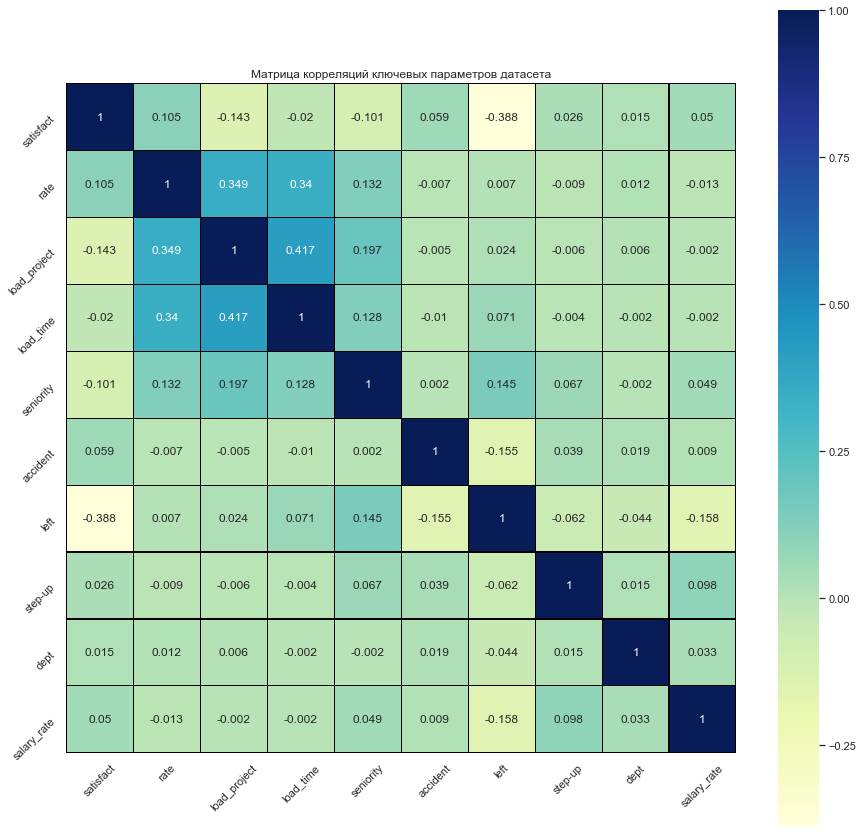

In [15]:
sns.set(rc={'figure.figsize':(15,15)})
ax = sns.heatmap(m_corr.round(3),  
                annot = True, 
                fmt='.3g', 
                cmap= 'YlGnBu', 
                linewidths=0.1, 
                linecolor='black', 
                square=True)

plt.title('Матрица корреляций ключевых параметров датасета')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)


Наибольший уровень корреляции зафиксирован между показателями:

- load_project и  load_time (0,417) - чем больше сотрудник тянет проектов тем больше затрачивает рабочего времени (все логично), уровень корреляции очень высок / предельно допустим. при этом показатель load_project - показатель более значим с точки зрения эффективности бизнеса,  load_time - более  субъективен / обратной стороной показателя может быть недостаток квалификации, избыток лояльности и прочие плохо оцифровываемые факторы за рамками настоящего анализа (load_time - кандидат на выброс)
- rate  и load_project (0,349), rate и load_time (0,340) - допускаю, чтo rate - оценка сотрудника которая рассчитывается на основании других факторов, уже участвующих в модели (прежде всего уровня нагрузки, инцидентов и т п, самостоятельная информативность показателя может быть невелика - гипотеза) (rate - кандидат на выброс)

4   Визуализировать несколько взаимосвязей между переменными

5   С использованием t-test статистики проверить взаимосвязи между несколькими переменными

10  Проверить несколько гипотез для данных, чтобы понять почему сотрудники покидают компанию

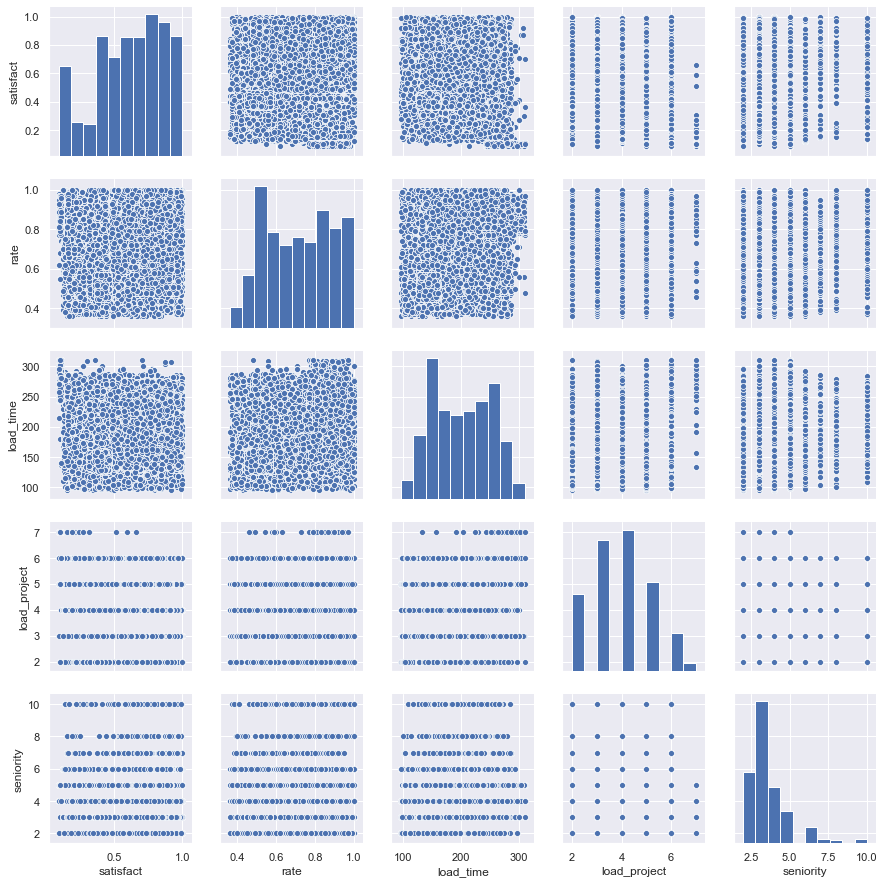

In [16]:
sns.pairplot(data, vars=[  'satisfact', 
                            'rate',
                            'load_time', 
                            'load_project',
                            'seniority'], 
                     kind=  'scatter')
plt.show()

In [17]:
# Тест Шапиро - Уилка на нормальность
from scipy.stats import shapiro
statsh1, psh1 = shapiro(data['satisfact'])
statsh2, psh2 = shapiro(data['rate'])
statsh3, psh3 = shapiro(data['load_time'])
statsh4, psh4 = shapiro(data['load_project'])
statsh5, psh5 = shapiro(data['seniority'])
print(psh1, psh2, psh3, psh4, psh5)
# Нормальных распределений нет

0.0 0.0 0.0 0.0 0.0


C:\Users\admin\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Исследуем текучесть кадров во взаимосвязи со стажем и уровнем оплаты труда

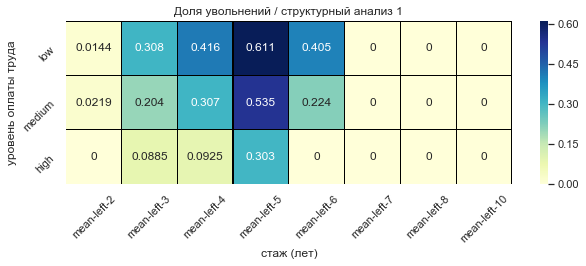

In [18]:
table_1 = pd.pivot_table(data, 
                       values =  ['left'],  
                       index =   ['salary'], 
                       columns = ['seniority'], 
                       aggfunc = ['mean'])

fig, ax = plt.subplots(figsize=(10,3))
sns.heatmap(table_1.iloc[[1,2,0]], 
           annot = True, 
           fmt='.3g', 
           cmap= 'YlGnBu', 
           linewidths=0.1, 
           linecolor='black')

plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.xlabel('стаж (лет)')
plt.ylabel('уровень оплаты труда')
plt.title('Доля увольнений / структурный анализ 1')

i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)
plt.show()

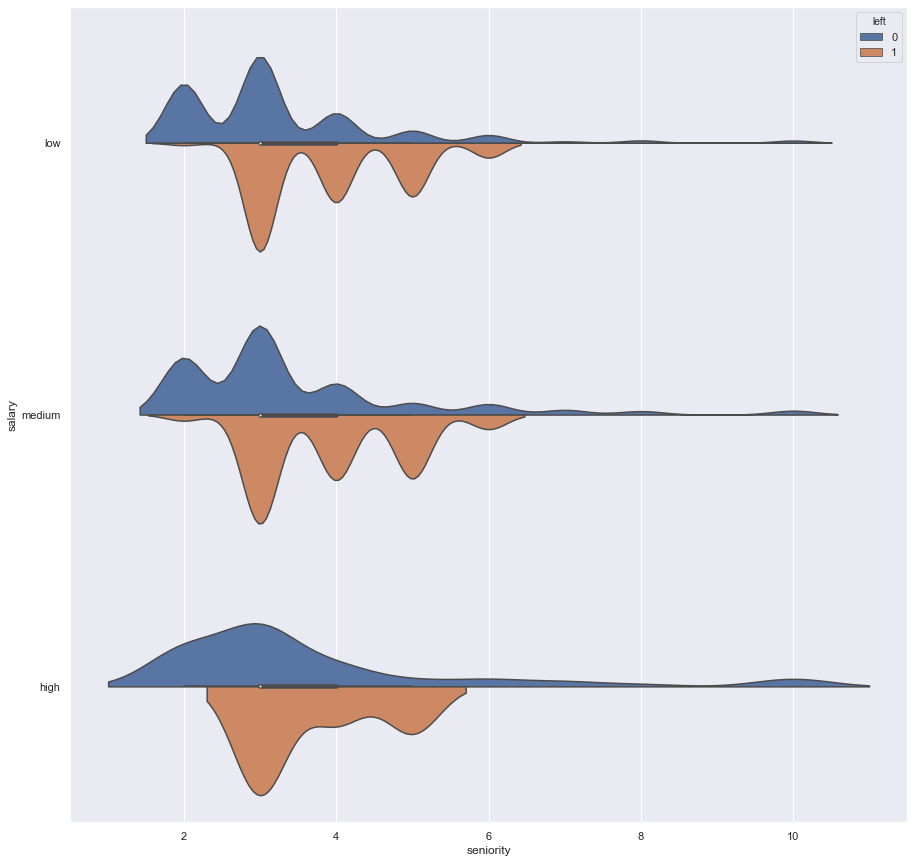

In [19]:
# рассмотрим структуру уволившихся и работающих в разрезе стаж / уровень оплаты труда
sns.violinplot(x ='seniority', y ='salary', data = data, hue ='left', split = True)

Очевидные концентрации увольнений:
    - стаж от 2 до 6 лет (пик по количеству в 3 года, пик по удельному весу в 5 лет);
    - уровень оплаты труда средний и ниже (в основном - низкий, пики те же)

Посмотрим, действительно ли связаны показатели стажа и факта увольнения, 
уровня оплаты труда и увольнения

In [31]:
from scipy.stats import kendalltau
sk1, pk1 = kendalltau(data['seniority'], data['left'])
print('Стаж / увольнение :','stat=%.3f, p=%.3f' % (sk1, pk1))
if pk1 > 0.05:
    print('Показатели независимы')
else:
    print('Показатели зависимы')
    
sk2, pk2 = kendalltau(data['salary_rate'], data['left'])
print('Стаж / уровень оплаты :','stat=%.3f, p=%.3f' % (sk2, pk2))
if pk2 > 0.05:
    print('Показатели независимы')
else:
    print('Показатели зависимы')

Стаж / увольнение : stat=0.245, p=0.000
Показатели зависимы
Стаж / уровень оплаты : stat=-0.148, p=0.000
Показатели зависимы


Проверим статистически / подвердим гипотезы выявленные в рамках структурного анализа

In [21]:
midd_seniority = data[(data['seniority']>3)&
                      (data['seniority']<7)]['left'].sample(1000)
full_seniority = data['left'].sample(1000)

stat, p = mannwhitneyu(midd_seniority, full_seniority)

print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably independent')
else:
	print('Probably dependent')
print('По результатам Т-теста: выборка наблюдений сотрудников со стажем 4-6 лет',
      'существенно отличается по статистике увольнений от выборки в целом,  ',
      'stat =',    stat.round(3),
      'p value =', p.round(3),
      ', статистически схожи оценки влияния на увольнения ',
      'между целевой группой и выборкой в целом') 

stat=413500.000, p=0.000
Probably dependent
По результатам Т-теста: выборка наблюдений сотрудников со стажем 4-6 лет существенно отличается по статистике увольнений от выборки в целом,   stat = 413500.0 p value = 0.0 , статистически схожи оценки влияния на увольнения  между целевой группой и выборкой в целом


In [22]:
low_salary_left  = data[data['salary_rate']== 0]['left']
high_salary_left = data[data['salary_rate']== 2]['left']

print('По результатам Т-теста влияния уровня зарплаты на % увольнений:  stat =', 
      mannwhitneyu(low_salary_left, high_salary_left)[0].round(3),
      'p value =', 
      mannwhitneyu(low_salary_left, high_salary_left)[1].round(3), 
      ' статистически схожи оценки влияния на увольнения ',
      'между выборками сотрудников с высоким и низким доходом') 

По результатам Т-теста влияния уровня зарплаты на % увольнений:  stat = 3481520.0 p value = 0.0  статистически схожи оценки влияния на увольнения  между выборками сотрудников с высоким и низким доходом


Далее исключаем из выборки наблюдений группы сотрудников, по которым уровень увольнений незначителен в  доле и/ или в объеме выборки  и углубляемся в анализы

из состава выборки отсекаем группы по стажу и уровню оплаты труда, наименее склонные к увольнениям. 
На представленной выборке (очищенной выше)
исследуем текучесть кадров во взаимосвязи с уровнем почасовой нагрузки и рейтингом сотрудника  

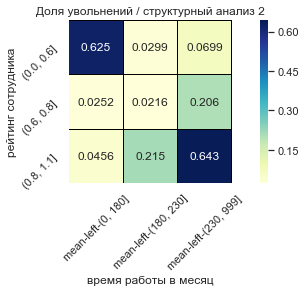

In [23]:
data_pt1 = data[ (data['salary_rate'] < 2)& 
                 (data['seniority']   > 2)&
                 (data['seniority']   < 7)]

rate_level      = pd.cut(data_pt1['rate'],      [0, 0.6,  0.8,  1.1]) 
load_time_level = pd.cut(data_pt1['load_time'], [0, 180,  230, 999]) 

table_2 = pd.pivot_table(data_pt1, 
                       values =['left'],  
                       index = rate_level, 
                       columns = load_time_level, 
                       aggfunc = ['mean'])

fig, ax = plt.subplots(figsize=(10,3))
sns.heatmap(table_2, 
           annot = True, 
           fmt='.3g', 
           cmap= 'YlGnBu', 
           linewidths=0.1, 
           linecolor='black', 
           square=True, 
           ax=ax)

plt.xlabel('время работы в месяц')
plt.ylabel('рейтинг сотрудника')
plt.title('Доля увольнений / структурный анализ 2')
plt.xticks(rotation=45)
plt.yticks(rotation=45)

i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)
plt.show()

очевидны 2 группы наблюдаемых, склонных к увольнению:
- работники, отрабатывающие ровно 40 часов в неделю и имеющие скромный рейтинг по результатам работы (увольнение которых связано только с издержками HR, но не влияют на эффективность бизнеса в целом);
- работники, вкалывающие сверхурочно на 25% и более сверх контракта и имеющие превосходный рейтинг (увольнение которых способно негативно сказаться на эффективности бизнеса).

C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


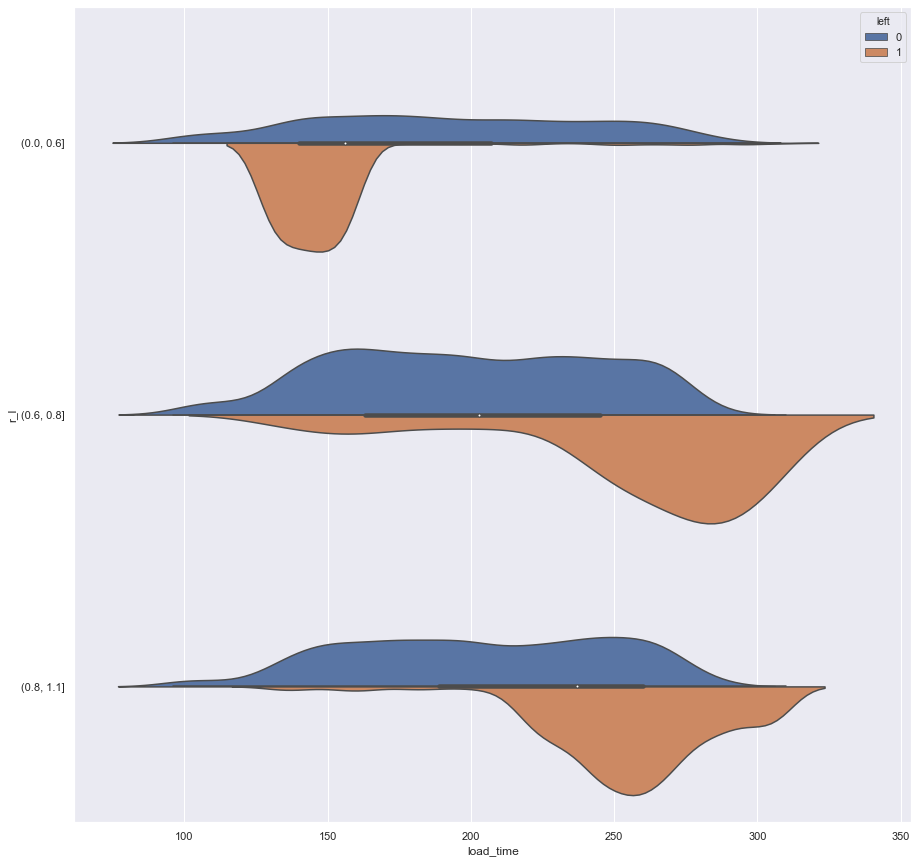

In [24]:
# Подтвердим наглядно еще раз
data_pt1['r_l'] = rate_level
sns.violinplot(x ='load_time', y ='r_l', data = data_pt1, hue ='left', split = True)

In [25]:
# подтвердим наличие статистических различий между 2 выявленными фокус группами
low_rate_load  = data_pt1[(data_pt1['rate']     < 0.6)& 
                          (data_pt1['load_time']< 180)]['left']

high_rate_load = data_pt1[(data_pt1['rate']     > 0.8)& 
                          (data_pt1['load_time']> 230)]['left']

stat, p = mannwhitneyu(low_rate_load, high_rate_load)

print('По результатам теста: выборка наблюдений двух разных групп сотрудников ',
      'имеют значительные статистические различия',
      'stat =',    stat.round(3),
      'p value =', p.round(3))

По результатам теста: выборка наблюдений двух разных групп сотрудников  имеют значительные статистические различия stat = 2527122.0 p value = 0.443


В подгруппе с низким рейтингом пик увольнений приходится на работников, 
занятых менее 40 часов в неделю (неполный рабочий день).
в каких же отделах работают эти прекрасные люди и 
какой уровень текучести кадров по каждой подгруппе ?

In [26]:
table_99 = pd.pivot_table(data_pt1[(data_pt1['rate'] < 0.6)& 
                         (data_pt1['load_time']< 168)], 
                          values =['rate'],  
                          index = ['sales'],
                          columns = ['left'], 
                          aggfunc = ['count'])

table_99.columns = ['Работает', 'Уволено']
table_99['Уволено, %'] = (100 * table_99['Уволено'] / 
                         (table_99['Работает'] + table_99['Уволено'])).round(2)   
table_99

,Работает,Уволено,"Уволено, %"
sales,,,
IT,50,109,68.55
RandD,43,43,50.00
accounting,40,87,68.50
hr,30,106,77.94
management,11,38,77.55
marketing,34,95,73.64
product_mng,38,83,68.60
sales,182,459,71.61
support,105,229,68.56


Группа HR-ов с низким профессиональным рейтингом на 0.8 ставки - с текучестью кадров в 78 %
не может не настораживать квалифицированного аналитика данных

Рассмотрим наиболее ценную для бизнеса группу - высоквалифицированных сотрудников (с высоким рейтингом), работающих сверхурочно. На представленной выборке  исследуем текучесть кадров во взаимосвязи с фактом повышения по службе и количеством ведомых проектов

C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


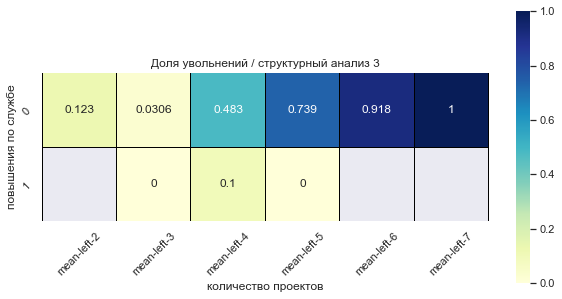

In [27]:
data_pt2 = data_pt1[(data['rate']      > 0.8)&
                    (data['load_time'] > 230)]

table_3 = pd.pivot_table(data_pt2, 
                       values =['left'],  
                       index = ['step-up'], 
                       columns = ['load_project'], 
                       aggfunc = ['mean'])

fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(table_3, 
           annot = True, 
           fmt='.3g', 
           cmap= 'YlGnBu', 
           linewidths=0.1, 
           linecolor='black', 
           square=True, 
           ax=ax)

plt.xlabel('количество проектов')
plt.ylabel('повышения по службе')
plt.title('Доля увольнений / структурный анализ 3')

plt.xticks(rotation=45)
plt.yticks(rotation=45)
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)
plt.show()


Критическими факторами решения об увольнении в фокус группе были факторы большого количества обслуживаемых проектов и отсутствия повышений по службе.

In [28]:
# Посмотрим с другой стороны 
# создаем модель - Деревья решений  - на тестовой выборке
output_y = data.left
input_x  = data.iloc[:, [0,1,2,3,4,5,7,10,11]]


from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
targets=(output_y==1)

Y= le.fit_transform(targets)

x_train, x_test, y_train, y_test = train_test_split(input_x, 
                                                    Y, 
                                                    test_size = 0.2, 
                                                    random_state = 100)
model=RandomForestClassifier(n_estimators=100)
model.fit(x_train,y_train)

# оценим качество модели
model_pred = model.predict(x_test)
print(classification_report(y_test, model_pred))
print('точность предсказания модели составила: ', 
      (100*model.score(x_test, y_test)).round(3),
       'процентов')

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2250
           1       0.99      0.98      0.99       750

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000

точность предсказания модели составила:  99.4 процентов


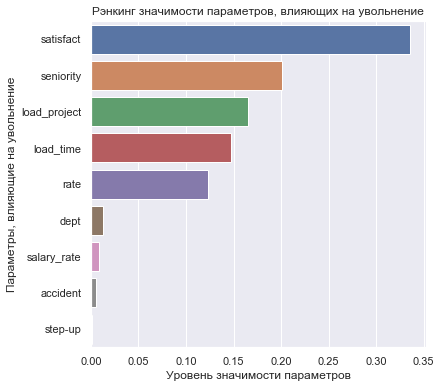

In [29]:
# формируем рэнкинг параметров по уровню значимости влияния на увольнение

headers = list(input_x.columns.values)
feature_imp = pd.Series(model.feature_importances_,index=headers).sort_values(ascending=False)
f, ax = plt.subplots(figsize=(6, 6))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Уровень значимости параметров')
plt.ylabel('Параметры, влияющие на увольнение')
plt.title("Рэнкинг значимости параметров, влияющих на увольнение")
plt.show()

Показатель уровня удовлетворенности,  выявленный в рамках последнего теста 
методом feature importance характеризуется следующими признаками:
    - высокий уровень корелляции между уровнем удовлетворенности и решением об увольнении
    - по условию задачи ничего не сказано (и не подразумевается) о методологии расчета 
satisfaction level, 
    - по сути показатель уровня удовлетворенности (может) описывает то же самое явление 
(как состояние (не)довольства), что и факт увольнения (как принятое решение)
    По приведенным основаниям я посчитал включение в анализ показателя satisfaction level 
по сути некорректным

ps: с другой - другой стороны:

ниже представлен feature_importances в отношении переменной satisfaction_level ...

по формальным признакам выходит:
чем больше сотрудники проводят времени на работе, тем меньше им все это нравится

копать надо глубже

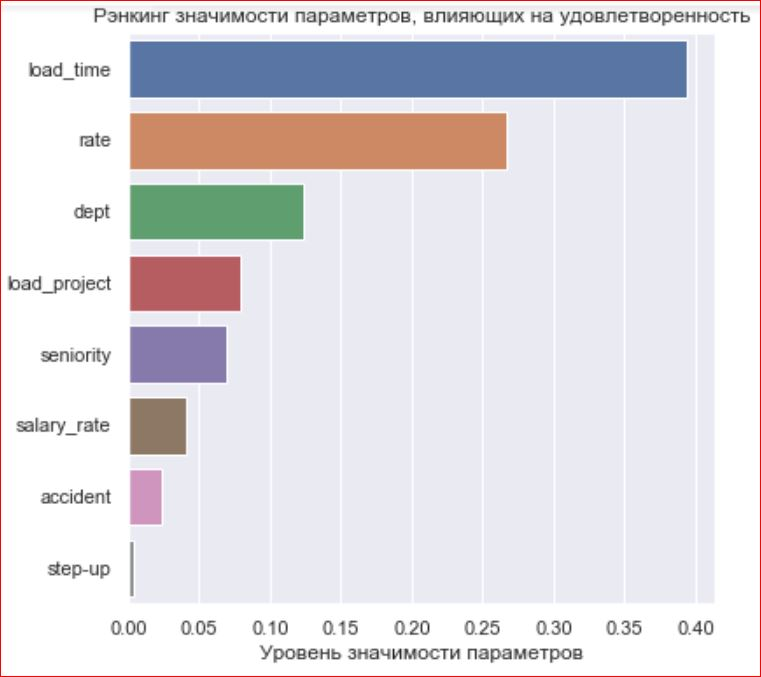

In [30]:
Image('Снимок.jpg', width=400)

ps2:  Задача была бы намного - намного интереснее при соблюдении следующих условий:
1. соответствие последовательностей: id датасета и табельный номер (или дата приема на работу) сотрудника (в датасете условие не соблюдено)
2. фиксация  в условии задачи методологии расчета стажа (например: для всех действующих сотрудников - единая дата наблюдения, для каждого уволенного - дата увольнения)

при соблюдении условия возможно было бы восстановить временные ряды и посмотреть динамику увольнений по поколениям